# LOGISTIC REGRESSION 
BrainStation


# Import the necessary libraries and dependencies
- One of python’s greatest benefits is the extensive line of powerful libraries. Using them well is the path to building great ML models!


In [153]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, classification_report, log_loss
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer, OneHotEncoder




In [3]:
# Loading the CSV file 

from google.colab import files
csv_data = files.upload()


Saving bank_small.csv to bank_small.csv


#  Exploratory Data Analysis (EDA) & Data cleaning

- In this section we familiarize ourselves with the data
- We check for outliers, missing values, categories

In [234]:
#Loading the CSV as a Pandas DataFrame

file_path = 'bank_small.csv'


bank_df = pd.read_csv(file_path, sep=',')
pd.set_option('display.max_columns', None)


print(bank_df.shape)   
bank_df.head(5)  

(15289, 5)


,loan,duration,poutcome,job,y
0,no,1042,unknown,admin.,yes
1,no,1467,unknown,admin.,yes
2,no,1389,unknown,technician,yes
3,no,579,unknown,services,yes
4,no,673,unknown,admin.,yes


In [227]:
# Basic information about the data

print(bank_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15289 entries, 0 to 15288
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   loan      15289 non-null  object
 1   duration  15289 non-null  int64 
 2   poutcome  15289 non-null  object
 3   job       15289 non-null  object
 4   y         15289 non-null  object
dtypes: int64(1), object(4)
memory usage: 597.4+ KB
None


In [5]:
# Another way to check for NULL values 

print(bank_df.isnull().sum())

'NaN' in bank_df

loan        0
duration    0
poutcome    0
job         0
y           0
dtype: int64


False

In [273]:
#Stats for numerical values

bank_df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,15289.0,330.878671,322.269855,0.0,124.0,222.0,417.0,3881.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


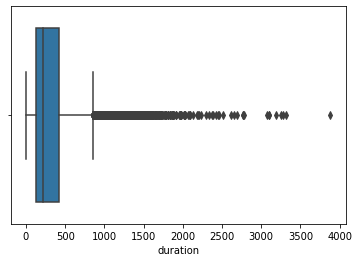

In [274]:
#Visualize outliers 

sns.boxplot(bank_df['duration'])


In [235]:
# Get the biggest outliers 

outliers = np.where(bank_df['duration']>3000)
print(f'The outliers are {outliers}')

The outliers are (array([  199,   345,   456,  1134,  1570,  1765,  7160, 14690]),)


In [236]:
#Show outliers together

bank_df.iloc[outliers[-1],:]

,loan,duration,poutcome,job,y
199,yes,3094,unknown,services,yes
345,no,3881,unknown,management,yes
456,yes,3183,unknown,admin.,yes
1134,yes,3253,unknown,self-employed,yes
1570,no,3102,unknown,admin.,yes
1765,yes,3076,unknown,blue-collar,yes
7160,no,3284,unknown,admin.,no
14690,no,3322,unknown,self-employed,no


In [237]:
# We drop the biggest outliers

for x in outliers:
  bank_df = bank_df.drop(x, axis = 0)


bank_df.shape

(15281, 5)

In [230]:
# Number of unique values in each column 

df_unique_values = pd.DataFrame([ [x, len(bank_df[x].unique())] for x in bank_df.columns], 
                         columns = ['Feature name', 'Number of unique values']).set_index('Feature name')   


df_unique_values


,Number of unique values
Feature name,
loan,2
duration,1443
poutcome,4
job,12
y,2


In [279]:
# Let's look at each column individually


# Y value - the label
y_values = bank_df.iloc[:,-1].value_counts()

print(y_values)


new_term_ratio = (y_values[1]/(y_values[0]+y_values[1]))*100

print(f'The precentage of clients that signed for a new term is {round(new_term_ratio,0)}%') 

no     9998
yes    5283
Name: y, dtype: int64
The precentage of clients that signed for a new term is 35.0%


In [280]:
# Job column 

print(f'Number of unique values: {bank_df.job.nunique()}')
bank_df.job.value_counts()


Number of unique values: 12


management       3374
blue-collar      2917
technician       2497
admin.           1848
services         1283
retired           964
self-employed     540
unemployed        468
student           442
entrepreneur      441
housemaid         414
unknown            93
Name: job, dtype: int64

In [281]:
# Fix the 'admin .' name

bank_df['job'] = bank_df['job'].replace(['admin.'], 'admin')

'admin.' in bank_df


False

In [282]:
# Poutcome column 

bank_df.poutcome.value_counts()

unknown    11787
failure     1692
success     1111
other        691
Name: poutcome, dtype: int64

In [238]:
# Drop the Poutcome 

bank_df = bank_df.drop('poutcome', axis=1)
bank_df.head(5)

,loan,duration,job,y
0,no,1042,admin.,yes
1,no,1467,admin.,yes
2,no,1389,technician,yes
3,no,579,services,yes
4,no,673,admin.,yes


In [284]:
# Loan column 

bank_df.loan.value_counts()

no     13034
yes     2247
Name: loan, dtype: int64

# DATA TRANSFORMATION STAGE

- Label encoding categorical or object data
- Test-train-split our data
- Standardizing numerical data

In [182]:
#Label encoding the 'loan' feature into 0 and 1


le = LabelEncoder()


bank_df['loan'] = le.fit_transform(bank_df['loan'])

bank_df['loan'].value_counts()


0    13034
1     2247
Name: loan, dtype: int64

In [183]:
#Label encoding our 'y' label into 0 and 1


bank_df['y'] = le.fit_transform(bank_df['y'])

bank_df['y'].value_counts()


#Another way to do it
#bank_df['y'] = bank_df['y'].apply(lambda x: 1 if x=='yes' else 0)

0    9998
1    5283
Name: y, dtype: int64

In [184]:
# Separate data into features (x) and label(y)


label_column = 'y'
y_label = bank_df[label_column]

#features
features = bank_df.drop('y', axis=1)

features.head()

,loan,duration,job
0,0,1042,admin.
1,0,1467,admin.
2,0,1389,technician
3,0,579,services
4,0,673,admin.


In [239]:
# Encode the 'job' feature with Pandas' get_dummies option


features_with_dummies = pd.get_dummies(features[['job']], drop_first=False)

# Add back the 'loan' and 'duration' feature columns
features_with_dummies['loan'] = features['loan']
features_with_dummies['duration'] = features['duration']



features_with_dummies.head(5)


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,loan,duration
0,1,0,0,0,0,0,0,0,0,0,0,0,0,1042
1,1,0,0,0,0,0,0,0,0,0,0,0,0,1467
2,0,0,0,0,0,0,0,0,0,1,0,0,0,1389
3,0,0,0,0,0,0,0,1,0,0,0,0,0,579
4,1,0,0,0,0,0,0,0,0,0,0,0,0,673


In [253]:
#Splitting our data to a train and a test set

X_train, X_test, y_train, y_test = train_test_split(features_with_dummies, y_label, test_size=0.25, random_state=0 )


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)



(11460, 14)
(11460,)
(3821, 14)
(3821,)


In [254]:
#Check for distribution of labels
y_train.value_counts(normalize=True)

0    0.650349
1    0.349651
Name: y, dtype: float64

In [241]:
#Scale our data 

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)

X_test_sc = sc.transform(X_test)

print(X_train_sc.shape)
print(X_test_sc.shape)
X_test_sc

(11460, 14)
(3821, 14)


array([[-0.36970154, -0.48234396, -0.1743279 , ..., -0.07839478,
        -0.41127747, -0.53319799],
       [-0.36970154,  2.07320934, -0.1743279 , ..., -0.07839478,
         2.43144856, -0.70099493],
       [-0.36970154, -0.48234396, -0.1743279 , ..., -0.07839478,
        -0.41127747, -0.71999081],
       ...,
       [-0.36970154, -0.48234396, -0.1743279 , ..., -0.07839478,
        -0.41127747,  2.98103977],
       [-0.36970154,  2.07320934, -0.1743279 , ..., -0.07839478,
        -0.41127747, -0.79597433],
       [ 2.70488458, -0.48234396, -0.1743279 , ..., -0.07839478,
        -0.41127747,  0.19814338]])

## FIT THE MODEL on the training data

In [277]:
#fit model
lr_model = LogisticRegression(class_weight={0:0.35,1:0.65}, penalty='l2').fit(X_train_sc, y_train)


## MAKE PREDICTIONS on test data

In [278]:
# Use the test data to make predictions
y_predicted = lr_model.predict(X_test_sc)




In [279]:
# Evaluate the results


print(f'The log_loss is {np.round(log_loss(y_test, y_predicted),2)}')

print(classification_report(y_test, y_predicted))



The log_loss is 8.08
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      2545
           1       0.64      0.68      0.66      1276

    accuracy                           0.77      3821
   macro avg       0.74      0.74      0.74      3821
weighted avg       0.77      0.77      0.77      3821



In [267]:
# Cross-validation strategy



X_kfold_sc = sc.fit_transform(features_with_dummies)


cv = KFold(n_splits=10, random_state=0, shuffle=True)
# create the LR model
lr_kfold = LogisticRegression() 
# evaluate model
scores = cross_val_score(lr_kfold, X_kfold_sc, y_label, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Average Accuracy and STD: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

print(scores)

Average Accuracy and STD: 0.768 (0.007)
[0.76324395 0.77945026 0.76897906 0.76701571 0.76897906 0.75458115
 0.77028796 0.76243455 0.76636126 0.77683246]


In [246]:
#Generate the confusion matrix

conf_matrix = confusion_matrix(y_test, y_predicted)

print(conf_matrix)




[[2309  236]
 [ 637  639]]


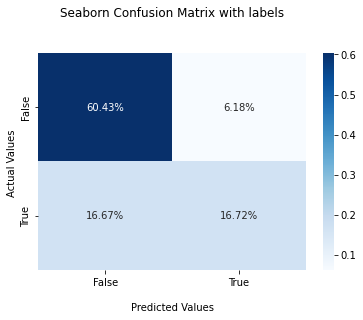

In [247]:
# Display the % visualization of the Confusion Matrix

ax = sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


plt.show()

In [201]:
# Let's check how accurate our model is!

check_client_number = 100

# We have to reshape the arrays first to be the same as when model was trained

reshaped_y = y_test.values.reshape(1,-1) 
reshaped_x = X_test_sc[check_client_number,:].reshape(1,-1)

print(f' The predicted label is {lr_model.predict(reshaped_x)}, the actual Churn value is {reshaped_y[0,check_client_number]} ')

 The predicted label is [1], the actual Churn value is 1 


## WHAT WAS THE MOST IMPORTANT OR INFLUENTIAL FEATURE?

Features: 0, Score: 0.04
Features: 1, Score: -0.28
Features: 2, Score: -0.08
Features: 3, Score: -0.07
Features: 4, Score: 0.11
Features: 5, Score: 0.22
Features: 6, Score: -0.01
Features: 7, Score: -0.07
Features: 8, Score: 0.21
Features: 9, Score: -0.01
Features: 10, Score: 0.04
Features: 11, Score: 0.02
Features: 12, Score: -0.33
Features: 13, Score: 1.43


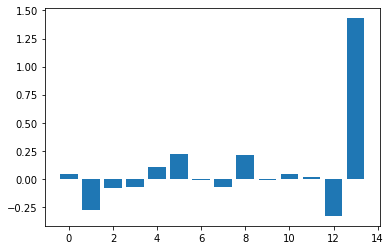

In [248]:
# Get coefficients

feature_importance = lr_model.coef_[0]



# Print feature importance
for x,y in enumerate(feature_importance):
	print('Features: %0d, Score: %.2f' % (x,y))
 


# Plot the features by their importance  
plt.bar([x for x in range(len(feature_importance))], feature_importance)
plt.show()
